# Simulations for $EJAB_{10}$

---

Desired graphs (from talk w Dr. Nathoo):
1. Sensitivity, precision wrt $n$  
2. ROC curve (Sensitivity vs 1-specificity as effect size varies)  
3. Collect all type 1 errors from fixed sample size and fixed $q$; plot density: Should be   uniform
   - This will be discussed later (i.e. during Friday's meeting)

To Do this week (due Friday): (1) and (2)

Note: Initially should be a simple t-test, we will then move to more complex models.

---

## Notes and definitions

### Sensitivity

$$
\text{sensitivity} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} \in [0,1]
$$

- The proportion actual positives correctly identified by the test
- E.g. if the a medical test for a disease detects 90/100 people who actually have the disease then the test has a sensitivity of 90%
- Interpretation: Higher sensitivity means fewer false negatives (type 2); the test rarely misses the positive cases

### Precision (positive predictive value)

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \in [0, 1]
$$

- The proportion of positive predictions that are actually correct
- E.g. if a medical test for a disease identifies 100 people as having the disease, but only 80 of those people actually have the disease, then the test has a precision of 80%
- Interpretation: Higher precision means fewer false positives (type 1); the test rarely mislabels negative cases as positive

### ROC curve

(Note: Defined differently from discussed; we will plot both)

- $\text{TPR} = \frac{\text{TP}}{\text{TP+FN}}$
- $\text{FPR} = 1 - \text{Specificity} = 1 - \frac{\text{TN}}{\text{TN+FP}} = \frac{\text{FP}}{\text{FP+TN}}$

**ROC curve w effect size**
   - TPR vs FPR as effect size varies
   - We will use Cohen's d: $d = \frac{\bar X_1 - \bar X_2}{S_{\text{pooled}}}$

## Summary for plots:

1. Sensitivity vs sample size $n$
2. Precision vs sample size $n$
3. ROC curve (TPR vs FPR) as effect size $d$ varies

---

## Code

In [1]:
import numpy as np
import scipy.stats as st

rng = np.random.default_rng(277)

# ----- settings -----
n_grid = np.linspace(10, 100, 100, dtype=int) # sample sizes for the x-axis
R = 5000                                           # replicates per (n)
d0 = 0.5                                           # effect size for H1
alpha = 0.05                                       # t-test threshold

# ----- helpers -----
def simulate_pvals(n, R, d_scalar, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    # R experiments of size n from N(d, 1)
    X = rng.normal(loc=d_scalar, scale=1.0, size=(R, n))
    # two-sided one-sample t-test per experiment (axis=1)
    res = st.ttest_1samp(X, popmean=0.0, axis=1, alternative='two-sided')
    return res.pvalue  # shape (R,)

def ejab01(n, pvals):
    # safe chi-square quantile to avoid inf at 0/1
    eps = 1e-12
    q = st.chi2.ppf(np.clip(1 - pvals, eps, 1 - eps), df=1)
    return np.sqrt(n) * np.exp(-0.5 * q * (n - 1) / n)

# ----- outputs to plot -----
sens_ejab = np.empty(len(n_grid))
prec_ejab = np.empty(len(n_grid))
sens_t    = np.empty(len(n_grid))
prec_t    = np.empty(len(n_grid))

# ----- main loop over n -----
for i, n in enumerate(n_grid):
    # H1 (positives in truth) and H0 (negatives in truth)
    p_H1 = simulate_pvals(int(n), R, d0, rng=rng)
    p_H0 = simulate_pvals(int(n), R, 0.0, rng=rng)

    # eJAB01 decisions
    dec_ejab_H1 = ejab01(int(n), p_H1) < 1
    dec_ejab_H0 = ejab01(int(n), p_H0) < 1

    TP = dec_ejab_H1.sum()
    FN = (~dec_ejab_H1).sum()
    FP = dec_ejab_H0.sum()
    TN = (~dec_ejab_H0).sum()

    sens_ejab[i] = TP / (TP + FN) if (TP + FN) else np.nan
    prec_ejab[i] = TP / (TP + FP) if (TP + FP) else np.nan

    # classical t-test decisions at alpha
    dec_t_H1 = p_H1 <= alpha
    dec_t_H0 = p_H0 <= alpha

    TP_t = dec_t_H1.sum()
    FN_t = (~dec_t_H1).sum()
    FP_t = dec_t_H0.sum()
    TN_t = (~dec_t_H0).sum()

    sens_t[i] = TP_t / (TP_t + FN_t) if (TP_t + FN_t) else np.nan
    prec_t[i] = TP_t / (TP_t + FP_t) if (TP_t + FP_t) else np.nan

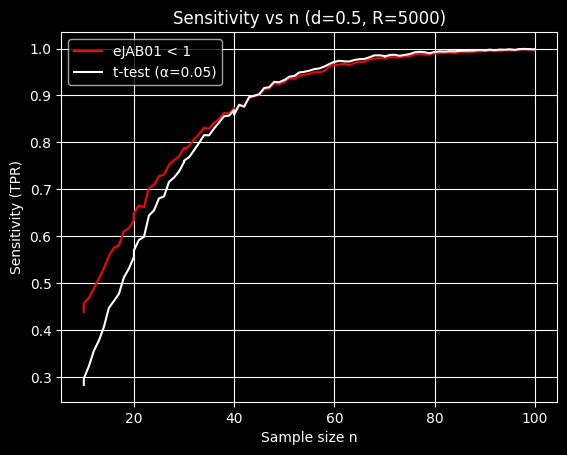

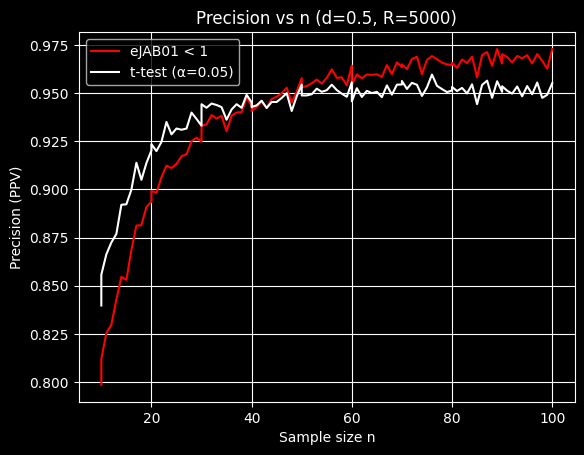

In [2]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.figure()
plt.plot(n_grid, sens_ejab, color='red', label='eJAB01 < 1')
plt.plot(n_grid, sens_t, color='white', label=f't-test (α={alpha})')
plt.xlabel('Sample size n'); plt.ylabel('Sensitivity (TPR)')
plt.title(f'Sensitivity vs n (d={d0}, R={R})'); plt.grid(True); plt.legend()

plt.figure()
plt.plot(n_grid, prec_ejab, color='red', label='eJAB01 < 1')
plt.plot(n_grid, prec_t, color='white', label=f't-test (α={alpha})')
plt.xlabel('Sample size n'); plt.ylabel('Precision (PPV)')
plt.title(f'Precision vs n (d={d0}, R={R})'); plt.grid(True); plt.legend()
plt.show()


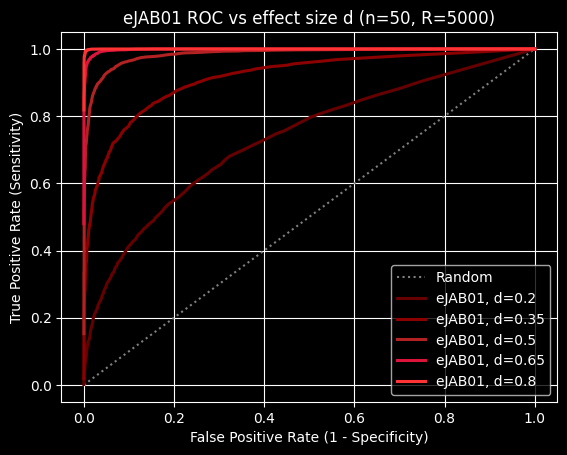

In [ ]:
# eJAB-only ROC across effect sizes
def roc_from_ejab(p_H1, p_H0, n, thr_grid):
    e1 = ejab01(int(n), p_H1)
    e0 = ejab01(int(n), p_H0)
    # decision: reject H0 if eJAB < τ
    tpr = np.array([np.mean(e1 < t) for t in thr_grid])
    fpr = np.array([np.mean(e0 < t) for t in thr_grid])
    return fpr, tpr

n_fixed = 50
d_grid = [0.2, 0.35, 0.5, 0.65, 0.8]
# alpha_grid = np.r_[0.0, np.logspace(-6, -1, 200), np.linspace(0.1, 1.0, 200)]  # (unused here; keep if needed elsewhere)
thr_grid   = np.logspace(-3, 1, 400)

colors = ['#660000', '#8B0000', '#B22222', '#DC143C', '#FF3333']

plt.figure()
plt.plot([0,1], [0,1], ':', color='gray', label='Random')

for d, c in zip(d_grid, colors):
    p_H1 = simulate_pvals(int(n_fixed), R, d, rng=rng)
    p_H0 = simulate_pvals(int(n_fixed), R, 0.0, rng=rng)
    fpr_e, tpr_e = roc_from_ejab(p_H1, p_H0, n_fixed, thr_grid)
    plt.plot(fpr_e, tpr_e, lw=2.2, color=c, label=f'eJAB01, d={d}')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'eJAB01 ROC vs effect size d (n={n_fixed}, R={R})')
plt.grid(True); plt.legend(); plt.show()



---

Here's some clarification, I will add these to the graphs as I see now that the labeling is   unclear:
- EJAB01 Sensitivity/precision vs n (Red lines)  
  - We first define the ejab01 decisions:  
    - `dec_ejab_H1 = ejab01(int(n), p_H1) < 1 # true effects`  
    - `dec_ejab_H0 = ejab01(int(n), p_H0) < 1 # false positives`  
  - We sum them to get totals to use in the sensitivity and precision plots:  
    - `TP = dec_ejab_H1.sum() # Num true positives as predicted by ejab`  
    - `FN = (~dec_ejab_H1).sum() # False negatives ... ejab`  
    - `FP = dec_ejab_H0.sum() # False positives ...`  
    - `TN = (~dec_ejab_H0).sum() # True negatives ...`  
  - We use these to compute sensitivity, precision:  
    - `sens_t[i] = TP_t / (TP_t + FN_t) if (TP_t + FN_t) else np.nan`  
    - `prec_t[i] = TP_t / (TP_t + FP_t) if (TP_t + FP_t) else np.nan`  
  - We compare with the actual results of the t-test alpha=0.05 (White lines)  
    - `dec_t_H1 = p_H1 <= alpha`  
    - `dec_t_H0 = p_H0 <= alpha`  
  
e.g.  
`plt.plot(n_grid, sens_ejab, color='red', label='eJAB01 < 1')`  
`plt.plot(n_grid, sens_t, color='white', label=f't-test (α={alpha})')`  
  
  
- For the ROC curves:  
  - The roc_from_ejabfunciton takes as input:  
    - Simulated p values with no/an effect (`p_H0`, `p_H1`)  
    - `n` (sample size)  
    - `thr_grid`: A log spaced array of possible decision thresholds t; "reject H0 if eJAB01   < t"
  - It uses these to calculate the TPR/FPR (True/false pos rates) (mean gives proportion of   values)
    - `tpr = np.array([np.mean(e1 < t) for t in thr_grid])`  
    - `fpr = np.array([np.mean(e0 < t) for t in thr_grid])`  
  - As requested, we plot far various effect sizes using cohen's d:  
    - `d_grid = [0.2, 0.35, 0.5, 0.65, 0.8]`  
  - The darker lines in the plot correspond to smaller effect sizes. We can see that, as   expected, for smaller effect sizes they approach x=y; truly random data. 
  - For larger effect size (lighter lines) the curves hug the y-axis, reflecting higher true   positive rates (greater sensitivity) for the same false positive rate.